In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import pickle
import gc

TRAIN_CSV = r'C:\Users\e0817820\Desktop\tokka\data\raw\train.csv'
TRAIN_COMBINE_CSV = r'C:\Users\e0817820\Desktop\tokka\data\raw\train_combine.csv'
TEST_CSV = r'C:\Users\e0817820\Desktop\tokka\data\raw\test.csv'
ADDITIONAL_TRAIN_CSV = r'C:\Users\e0817820\Desktop\tokka\data\raw\add_train.csv'
MODELS_DIR = r'C:\Users\e0817820\Desktop\tokka\models'
IMAGES_DIR = r'C:\Users\e0817820\Desktop\tokka\images'
JSON_DIR = r'C:\Users\e0817820\Desktop\tokka\json'

C:\Users\e0817820\AppData\Local\Temp\ipykernel_6540\4197269671.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_time_series_cross_val_splits(df, cv = 6, embargo = 3750):
    all_train_timestamps = df['timestamp'].unique()
    len_split = len(all_train_timestamps) // cv
    test_splits = [all_train_timestamps[i * len_split : (i + 1) * len_split] for i in range(cv)]
    rem = len(all_train_timestamps) - len_split*cv
    if rem>0:
        test_splits[-1] = np.append(test_splits[-1], all_train_timestamps[-rem:])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the timestamps that aren't in the test split
        train_split_not_embargoed = [e for e in all_train_timestamps if not (test_split_min <= int(e) <= test_split_max)]
        embargo_sec = 60*1000*embargo 
        train_split = [e for e in train_split_not_embargoed if
                       abs(int(e) - test_split_max) > embargo_sec and abs(int(e) - test_split_min) > embargo_sec]
        train_splits.append(train_split)
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip

In [3]:
params = {
            'early_stopping_rounds': 5, #best 5
            'objective': 'regression',
            'metric': 'rmse',
            'verbosity': -1,
            'boosting_type': 'gbdt', 
            # to add more parameters for each coin
            'bagging_freq': 1,
            'seed':20,
            'feature_fraction_seed': 20,
            'bagging_fraction_seed': 20,
            'data_random_seed': 20,
            'extra_trees': True,
            'extra_seed': 20,
            'zero_as_missing': True,
            "first_metric_only": True
        }

params_specific = {
            'ADA': { #feature_fraction': 1, 'bagging_fraction': 0.9221832643387833
              'max_depth': 5, 'lambda_l1': 0.0675613001654293, 'lambda_l2': 0.01034066164902201, 'learning_rate': 0.09127841477093228, 'min_data_in_leaf': 150, 'num_leaves': 28, 'feature_fraction': 1, 'bagging_fraction': 0.9221832643387833, 'max_bin': 358
              }
            }

In [4]:
# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
# (used in nyanp's Optiver solution)
def plot_importance(symbol, importances, features_names, PLOT_TOP_N = 20, figsize=(10, 10)):
    importance_df = pd.DataFrame(data=importances, columns=features_names)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()
    # save images
    plt.savefig(os.path.join(IMAGES_DIR, f'{symbol}.png'))
    

In [5]:
def correlation(a, train_data):
    b = train_data.get_label()
    
    a = np.ravel(a)
    b = np.ravel(b)

    len_data = len(a)
    mean_a = np.mean(a)
    mean_b = np.mean(b)
    var_a = np.var(a, ddof=0)  
    var_b = np.var(b, ddof=0)  
    
    cov = np.sum((a - mean_a) * (b - mean_b)) / len_data
    corr = cov / np.sqrt(var_a * var_b)

    return 'corr', corr, True

# For CV score calculation
def corr_score(preds, valid_data):
    valid = valid_data.get_label()
    return 'corr', correlation(preds, valid_data)[1], True  # True for maximization
list_cryptocurrencies = ['AVAX', 'ADA', 'SOL', 'BNB', 'TRX', 'DOGE', 'LINK', 'XRP', 'BTC', 'ETH']
# list_cryptocurrencies = ['LINK', 'XRP', 'BTC', 'ETH']


def train():
    for symbol in list_cryptocurrencies:
        gc.collect()
        target = f'log_return_{symbol}'
        
        df = pd.read_csv(rf"C:\Users\e0817820\Desktop\tokka\data\processed\train_{symbol}.csv")
        df_target = df[target]
        df_feature = df.drop(columns=[target, 'timestamp'])
        cv_splits = list(get_time_series_cross_val_splits(df, cv = 12, embargo = 3750))
        params_symbol = {**params, **params_specific['ADA']}
        print(f"Training {symbol} with params: {params_symbol}")
        features = df_feature.columns
        print(f"Features: {features}")
        corr_list, importances, oof_pred, oof_valid = [], [], [], []
        crypto_corrs, crypto_avg_corrs, crypto_oof_valid, crypto_oof_pred = [], [], [], []
        for split, [train_split, test_split] in enumerate(cv_splits):
            gc.collect()
            train_split_index = df['timestamp'].isin(train_split)
            test_split_index = df['timestamp'].isin(test_split)

            X_train, y_train = df_feature.loc[train_split_index], df_target.loc[train_split_index].values
            X_test, y_test = df_feature.loc[test_split_index], df_target.loc[test_split_index].values

            lgb_train = lgb.Dataset(X_train, y_train)
            lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

            gbm = lgb.train(params=params_symbol, train_set=lgb_train, valid_sets=[lgb_eval], feval=correlation, num_boost_round=5000, valid_names=['valid'])

            importances.append(gbm.feature_importance(importance_type='gain'))

            preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)
            model_file = os.path.join(MODELS_DIR, f'{symbol}_fold{split}_1.pkl')
            pickle.dump(gbm, open(model_file, 'wb'))
            print(f"Trained model was saved to '{symbol}_fold{split}_1.pkl'")
            corr = corr_score(preds, lgb_eval)
            corr_list.append(corr)
            oof_pred.append(preds)
            oof_valid.append(y_test)
            # break
        corrs = [x[1] for x in corr_list]
        avg_corr = np.mean(corrs)
        print(f"Average correlation: {avg_corr}")
        # for i in range(10):
        #     print(f"Split {i}")
        #     print(f"Corr: {corrs[i]}")
        plot_importance(symbol, np.array(importances), features, PLOT_TOP_N=20, figsize=(20, 16))
        crypto_corrs.append(corr_list)
        crypto_oof_pred.append(oof_pred)
        crypto_oof_valid.append(oof_valid)
        crypto_avg_corrs.append(avg_corr)
    return crypto_corrs, crypto_oof_pred, crypto_oof_valid, crypto_avg_corrs

Training AVAX with params: {'early_stopping_rounds': 5, 'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'bagging_freq': 1, 'seed': 20, 'feature_fraction_seed': 20, 'bagging_fraction_seed': 20, 'data_random_seed': 20, 'extra_trees': True, 'extra_seed': 20, 'zero_as_missing': True, 'first_metric_only': True, 'max_depth': 5, 'lambda_l1': 0.0675613001654293, 'lambda_l2': 0.01034066164902201, 'learning_rate': 0.09127841477093228, 'min_data_in_leaf': 150, 'num_leaves': 28, 'feature_fraction': 1, 'bagging_fraction': 0.9221832643387833, 'max_bin': 358}
Features: Index(['close_AVAX', 'log_close/mean_15_AVAX', 'log_return_15_AVAX',
       'log_close/mean_40_AVAX', 'log_return_40_AVAX',
       'log_close/mean_150_AVAX', 'log_return_150_AVAX',
       'log_close/mean_300_AVAX', 'log_return_300_AVAX',
       'log_close/mean_15-mean_close/mean_15_AVAX',
       'log_return_15-mean_log_returns_15_AVAX',
       'log_close/mean_40-mean_close/mean_40_AVAX',
       'l

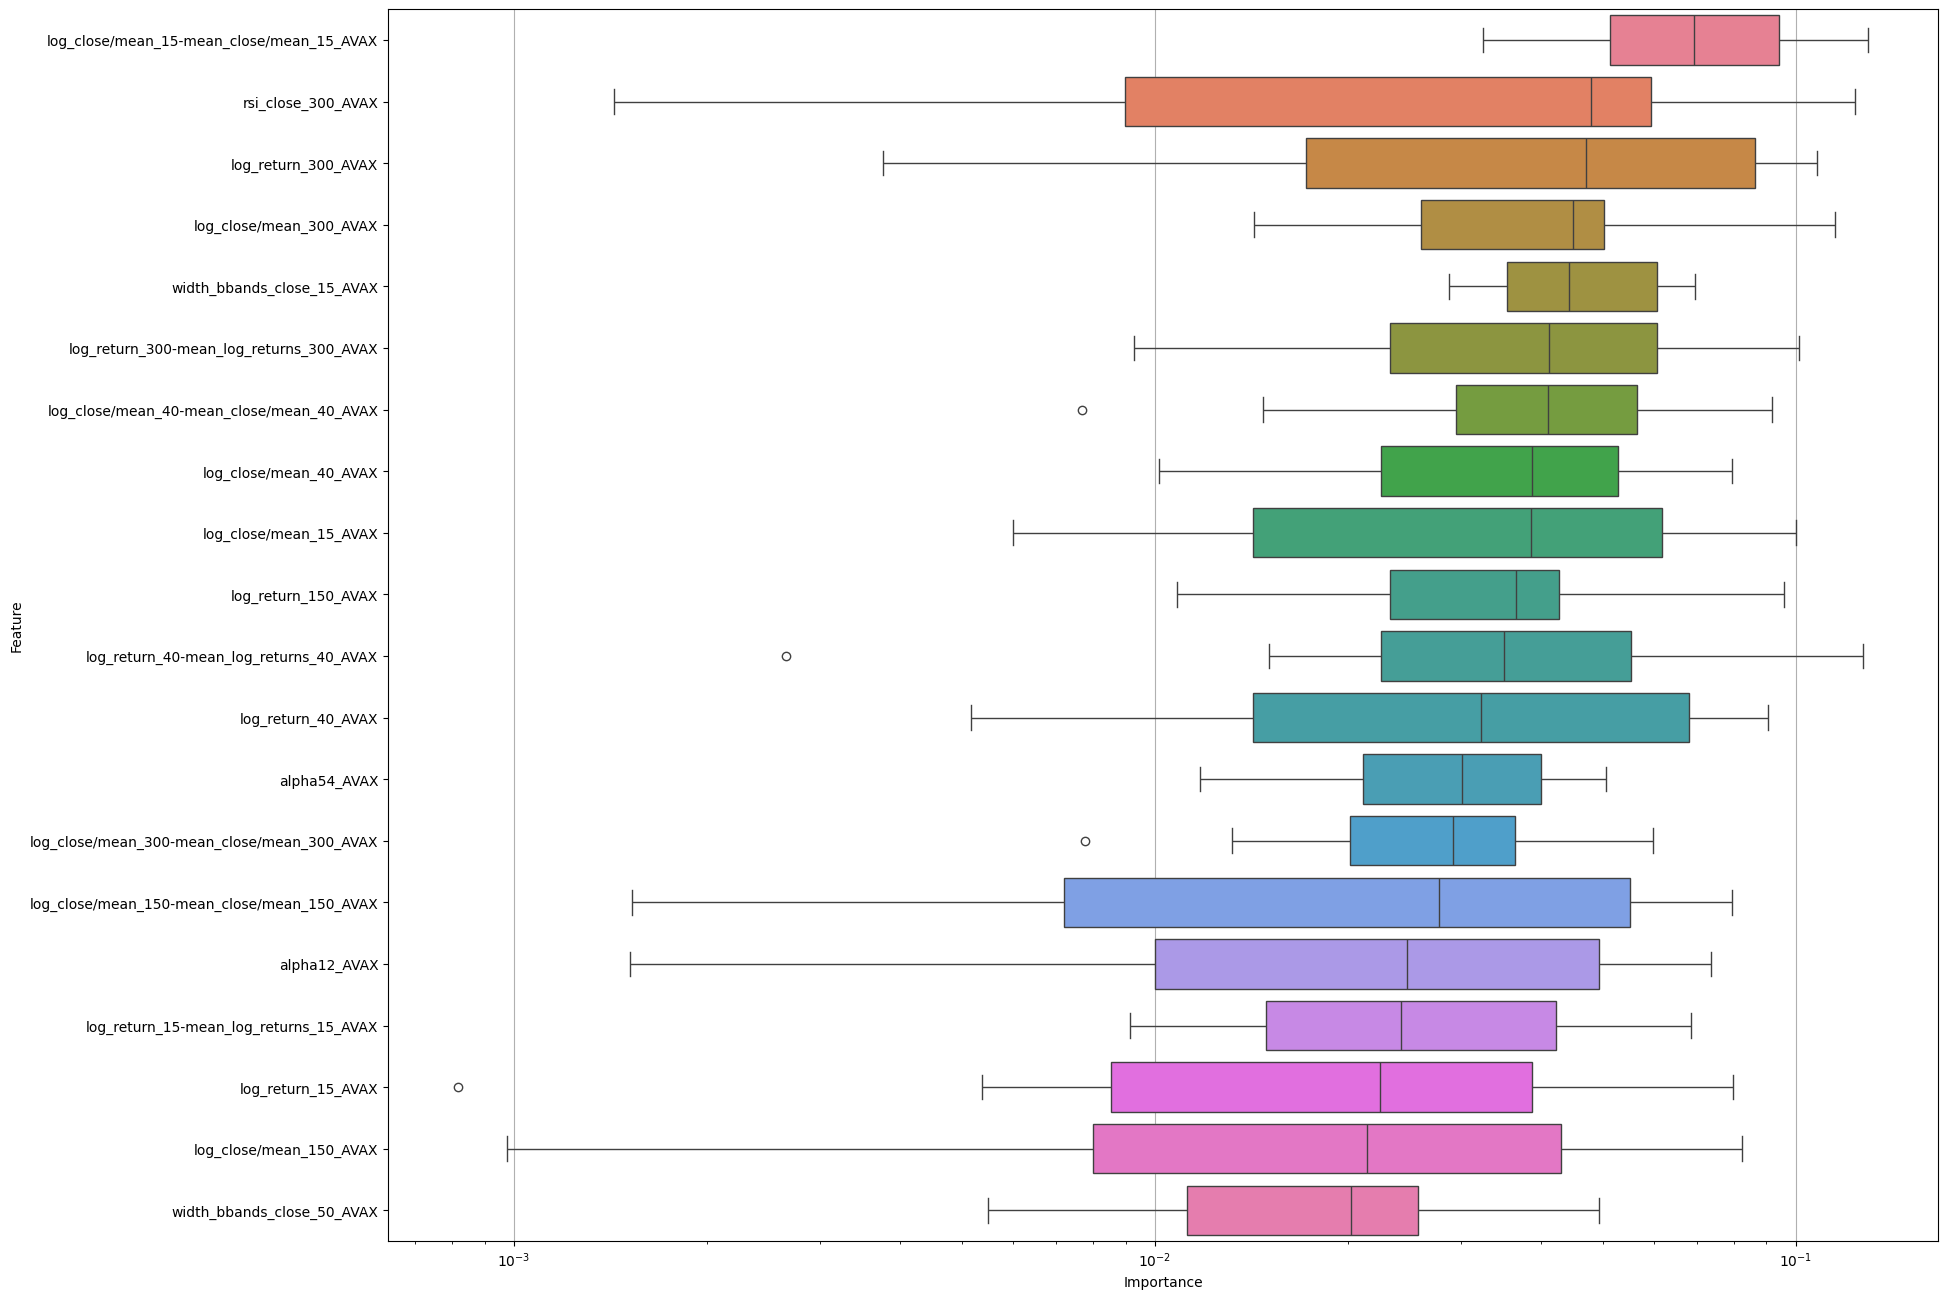

Training ADA with params: {'early_stopping_rounds': 5, 'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'bagging_freq': 1, 'seed': 20, 'feature_fraction_seed': 20, 'bagging_fraction_seed': 20, 'data_random_seed': 20, 'extra_trees': True, 'extra_seed': 20, 'zero_as_missing': True, 'first_metric_only': True, 'max_depth': 5, 'lambda_l1': 0.0675613001654293, 'lambda_l2': 0.01034066164902201, 'learning_rate': 0.09127841477093228, 'min_data_in_leaf': 150, 'num_leaves': 28, 'feature_fraction': 1, 'bagging_fraction': 0.9221832643387833, 'max_bin': 358}
Features: Index(['close_ADA', 'log_close/mean_15_ADA', 'log_return_15_ADA',
       'log_close/mean_40_ADA', 'log_return_40_ADA', 'log_close/mean_150_ADA',
       'log_return_150_ADA', 'log_close/mean_300_ADA', 'log_return_300_ADA',
       'log_close/mean_15-mean_close/mean_15_ADA',
       'log_return_15-mean_log_returns_15_ADA',
       'log_close/mean_40-mean_close/mean_40_ADA',
       'log_return_40-mean_lo

<Figure size 640x480 with 0 Axes>

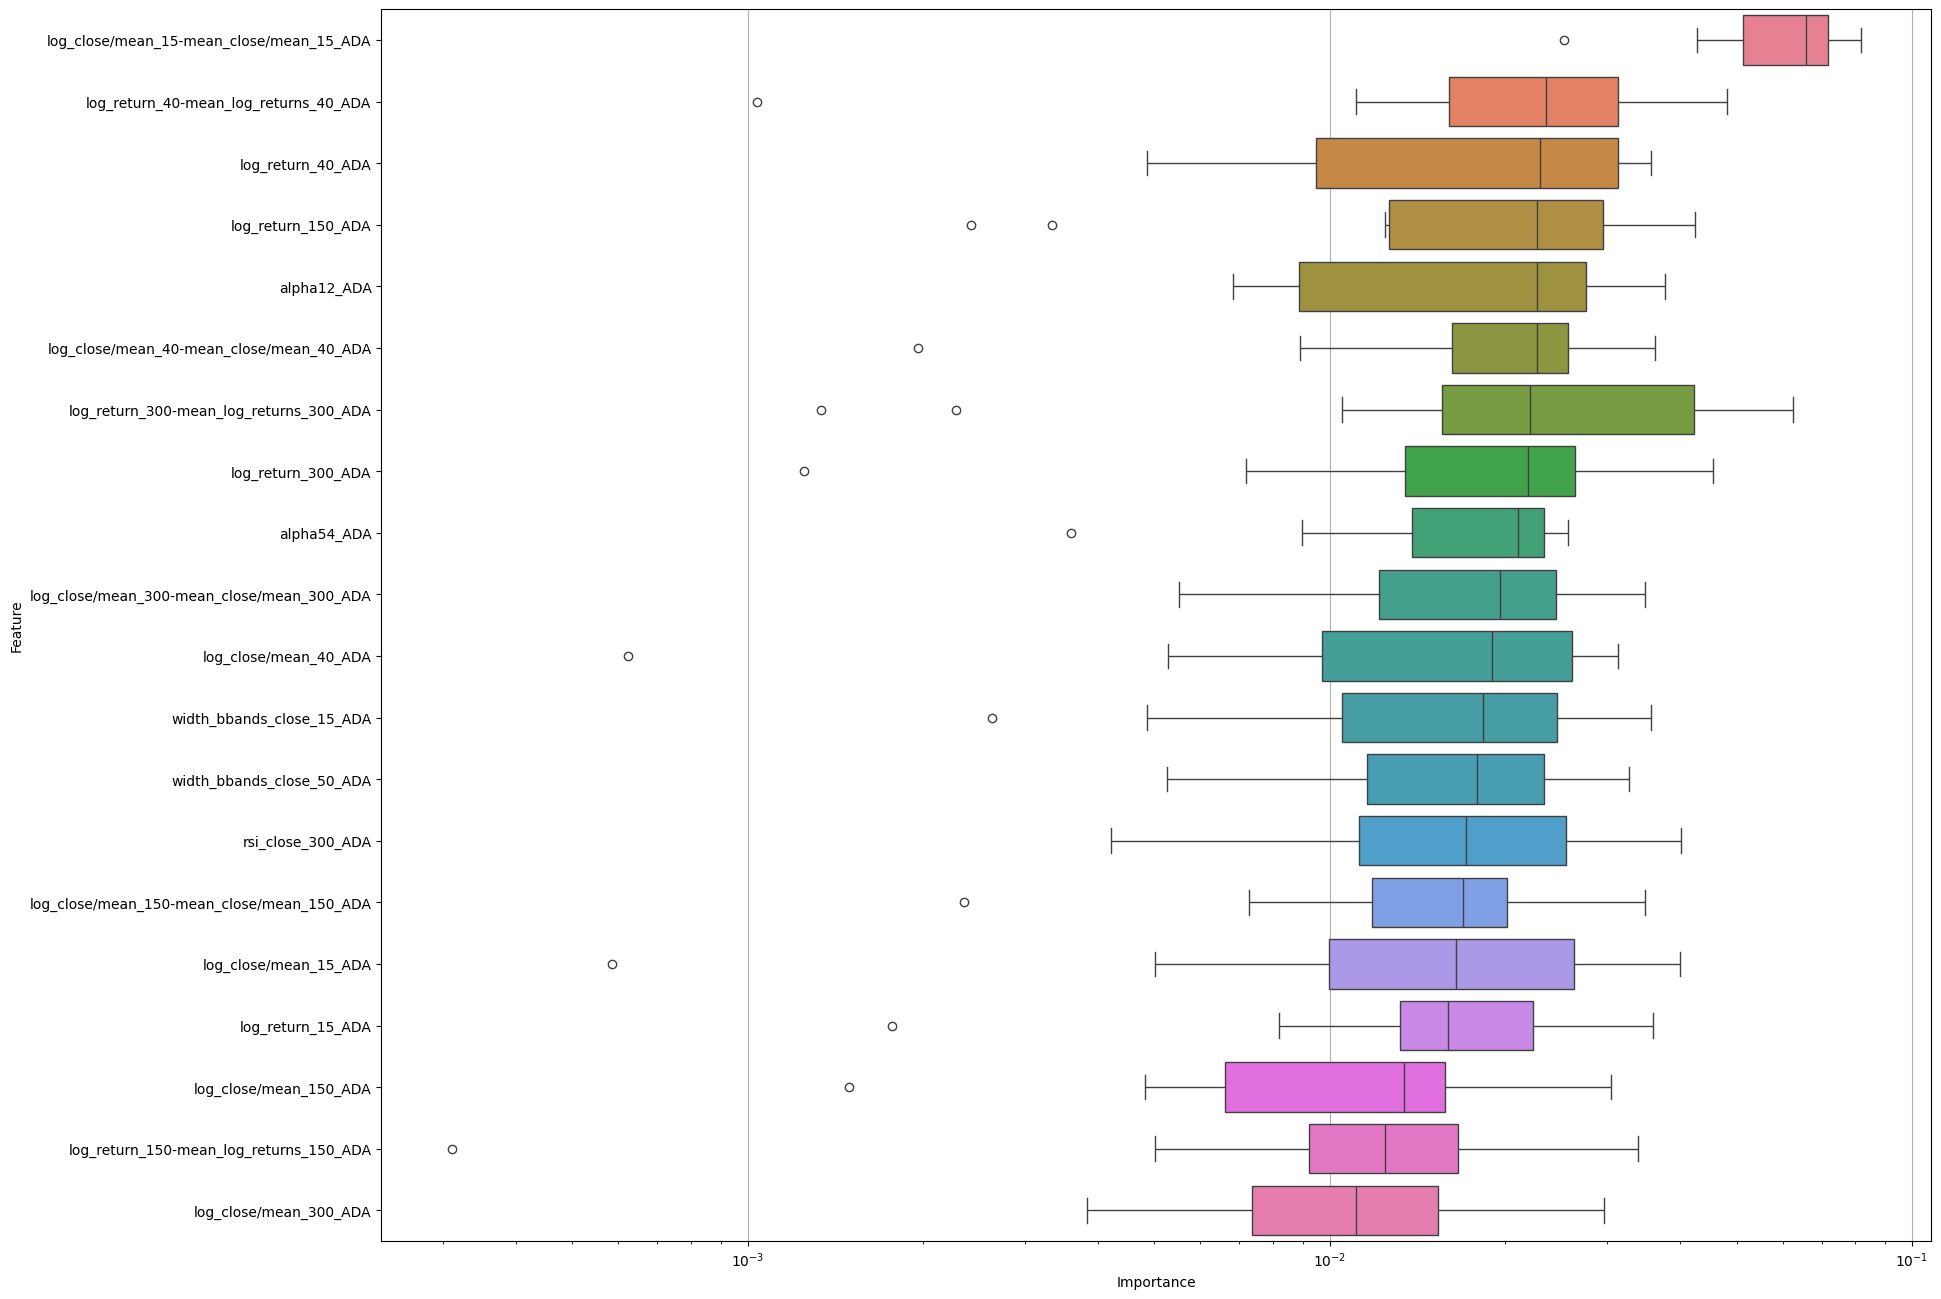

Training SOL with params: {'early_stopping_rounds': 5, 'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'bagging_freq': 1, 'seed': 20, 'feature_fraction_seed': 20, 'bagging_fraction_seed': 20, 'data_random_seed': 20, 'extra_trees': True, 'extra_seed': 20, 'zero_as_missing': True, 'first_metric_only': True, 'max_depth': 5, 'lambda_l1': 0.0675613001654293, 'lambda_l2': 0.01034066164902201, 'learning_rate': 0.09127841477093228, 'min_data_in_leaf': 150, 'num_leaves': 28, 'feature_fraction': 1, 'bagging_fraction': 0.9221832643387833, 'max_bin': 358}
Features: Index(['close_SOL', 'log_close/mean_15_SOL', 'log_return_15_SOL',
       'log_close/mean_40_SOL', 'log_return_40_SOL', 'log_close/mean_150_SOL',
       'log_return_150_SOL', 'log_close/mean_300_SOL', 'log_return_300_SOL',
       'log_close/mean_15-mean_close/mean_15_SOL',
       'log_return_15-mean_log_returns_15_SOL',
       'log_close/mean_40-mean_close/mean_40_SOL',
       'log_return_40-mean_lo

<Figure size 640x480 with 0 Axes>

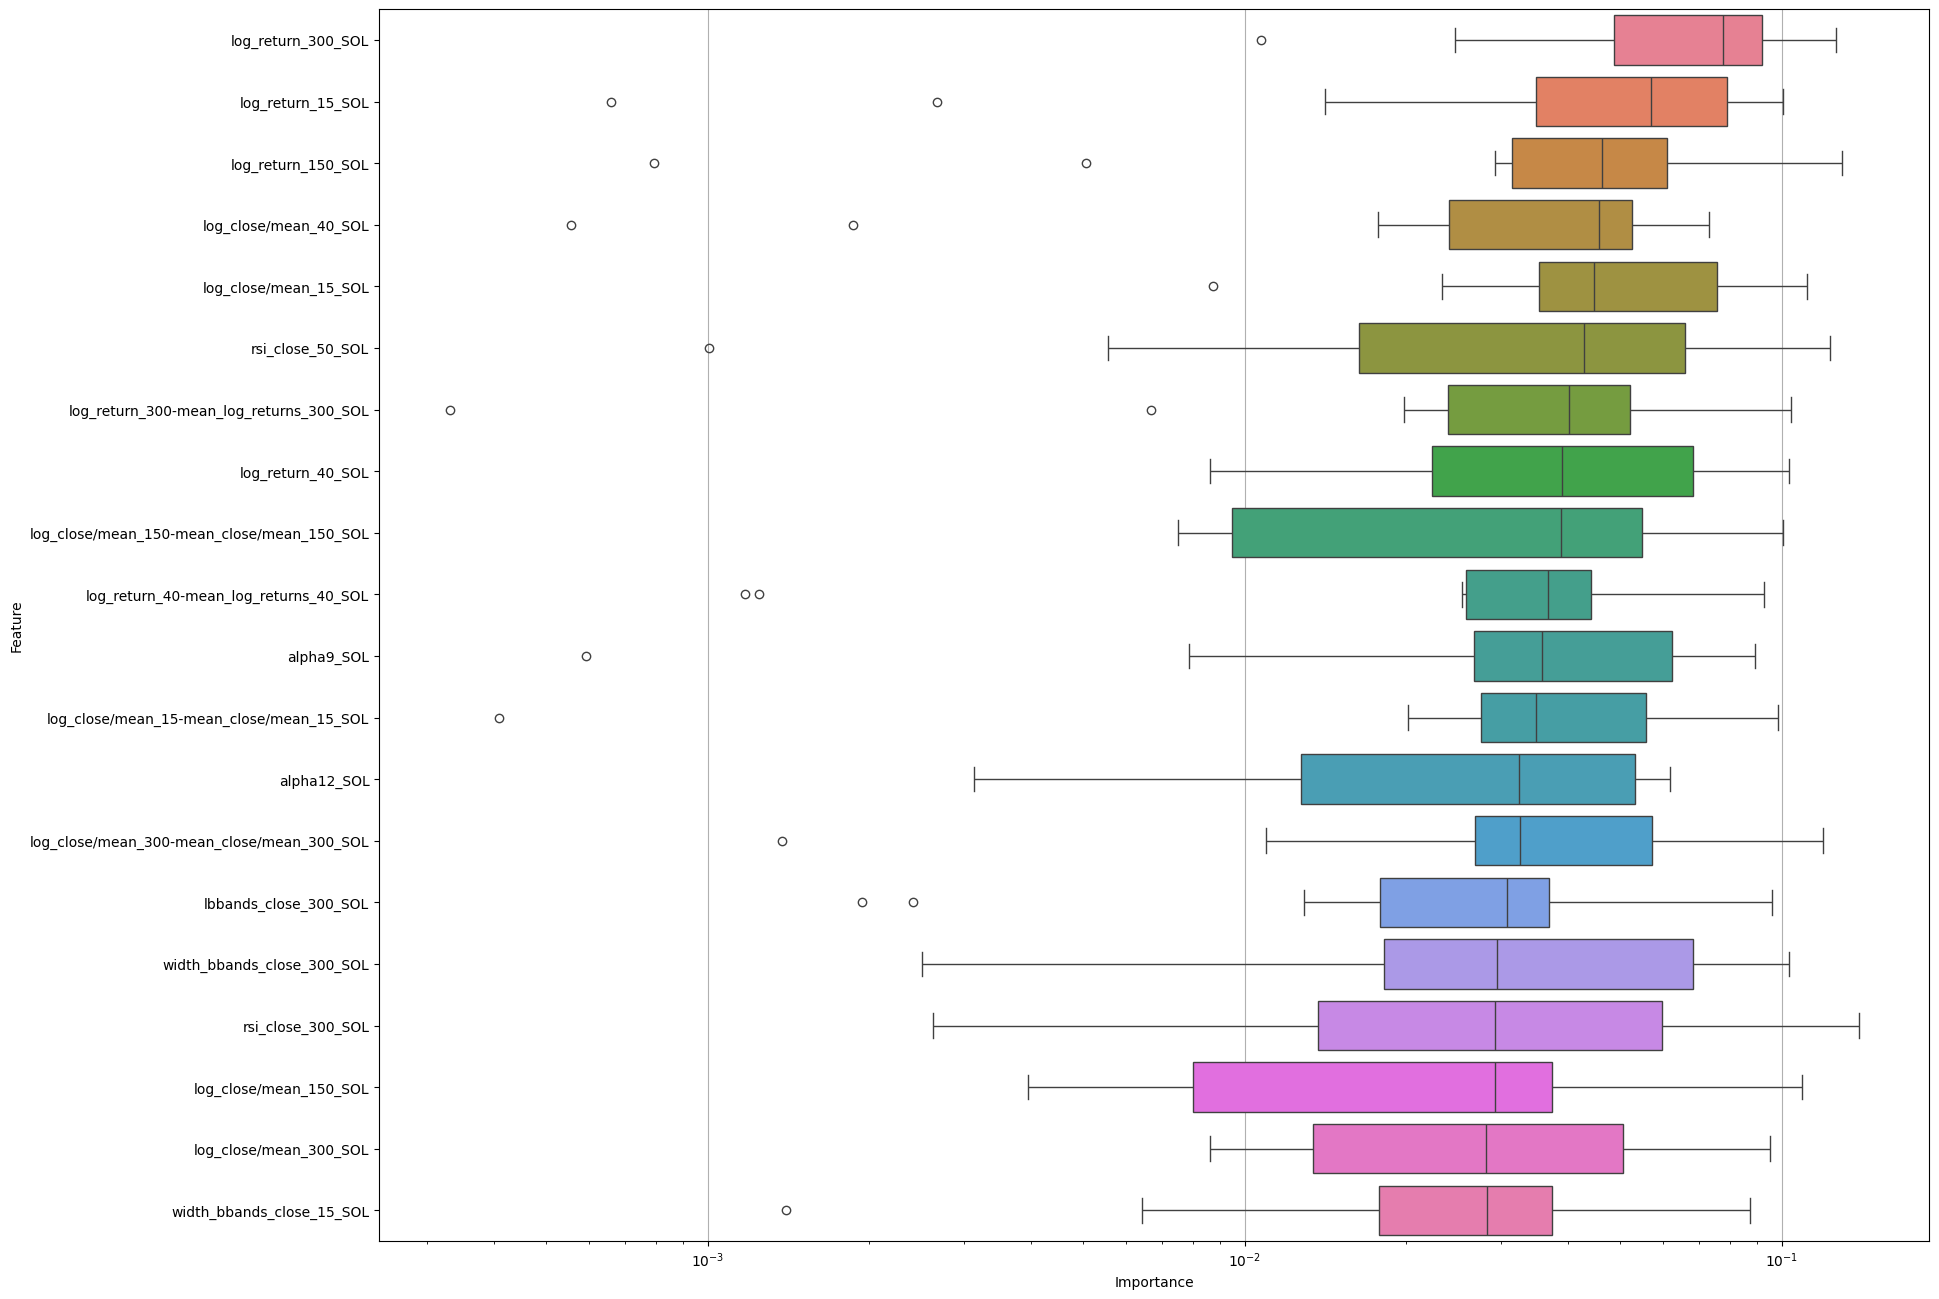

Training BNB with params: {'early_stopping_rounds': 5, 'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'bagging_freq': 1, 'seed': 20, 'feature_fraction_seed': 20, 'bagging_fraction_seed': 20, 'data_random_seed': 20, 'extra_trees': True, 'extra_seed': 20, 'zero_as_missing': True, 'first_metric_only': True, 'max_depth': 5, 'lambda_l1': 0.0675613001654293, 'lambda_l2': 0.01034066164902201, 'learning_rate': 0.09127841477093228, 'min_data_in_leaf': 150, 'num_leaves': 28, 'feature_fraction': 1, 'bagging_fraction': 0.9221832643387833, 'max_bin': 358}
Features: Index(['close_BNB', 'log_close/mean_15_BNB', 'log_return_15_BNB',
       'log_close/mean_40_BNB', 'log_return_40_BNB', 'log_close/mean_150_BNB',
       'log_return_150_BNB', 'log_close/mean_300_BNB', 'log_return_300_BNB',
       'log_close/mean_15-mean_close/mean_15_BNB',
       'log_return_15-mean_log_returns_15_BNB',
       'log_close/mean_40-mean_close/mean_40_BNB',
       'log_return_40-mean_lo

<Figure size 640x480 with 0 Axes>

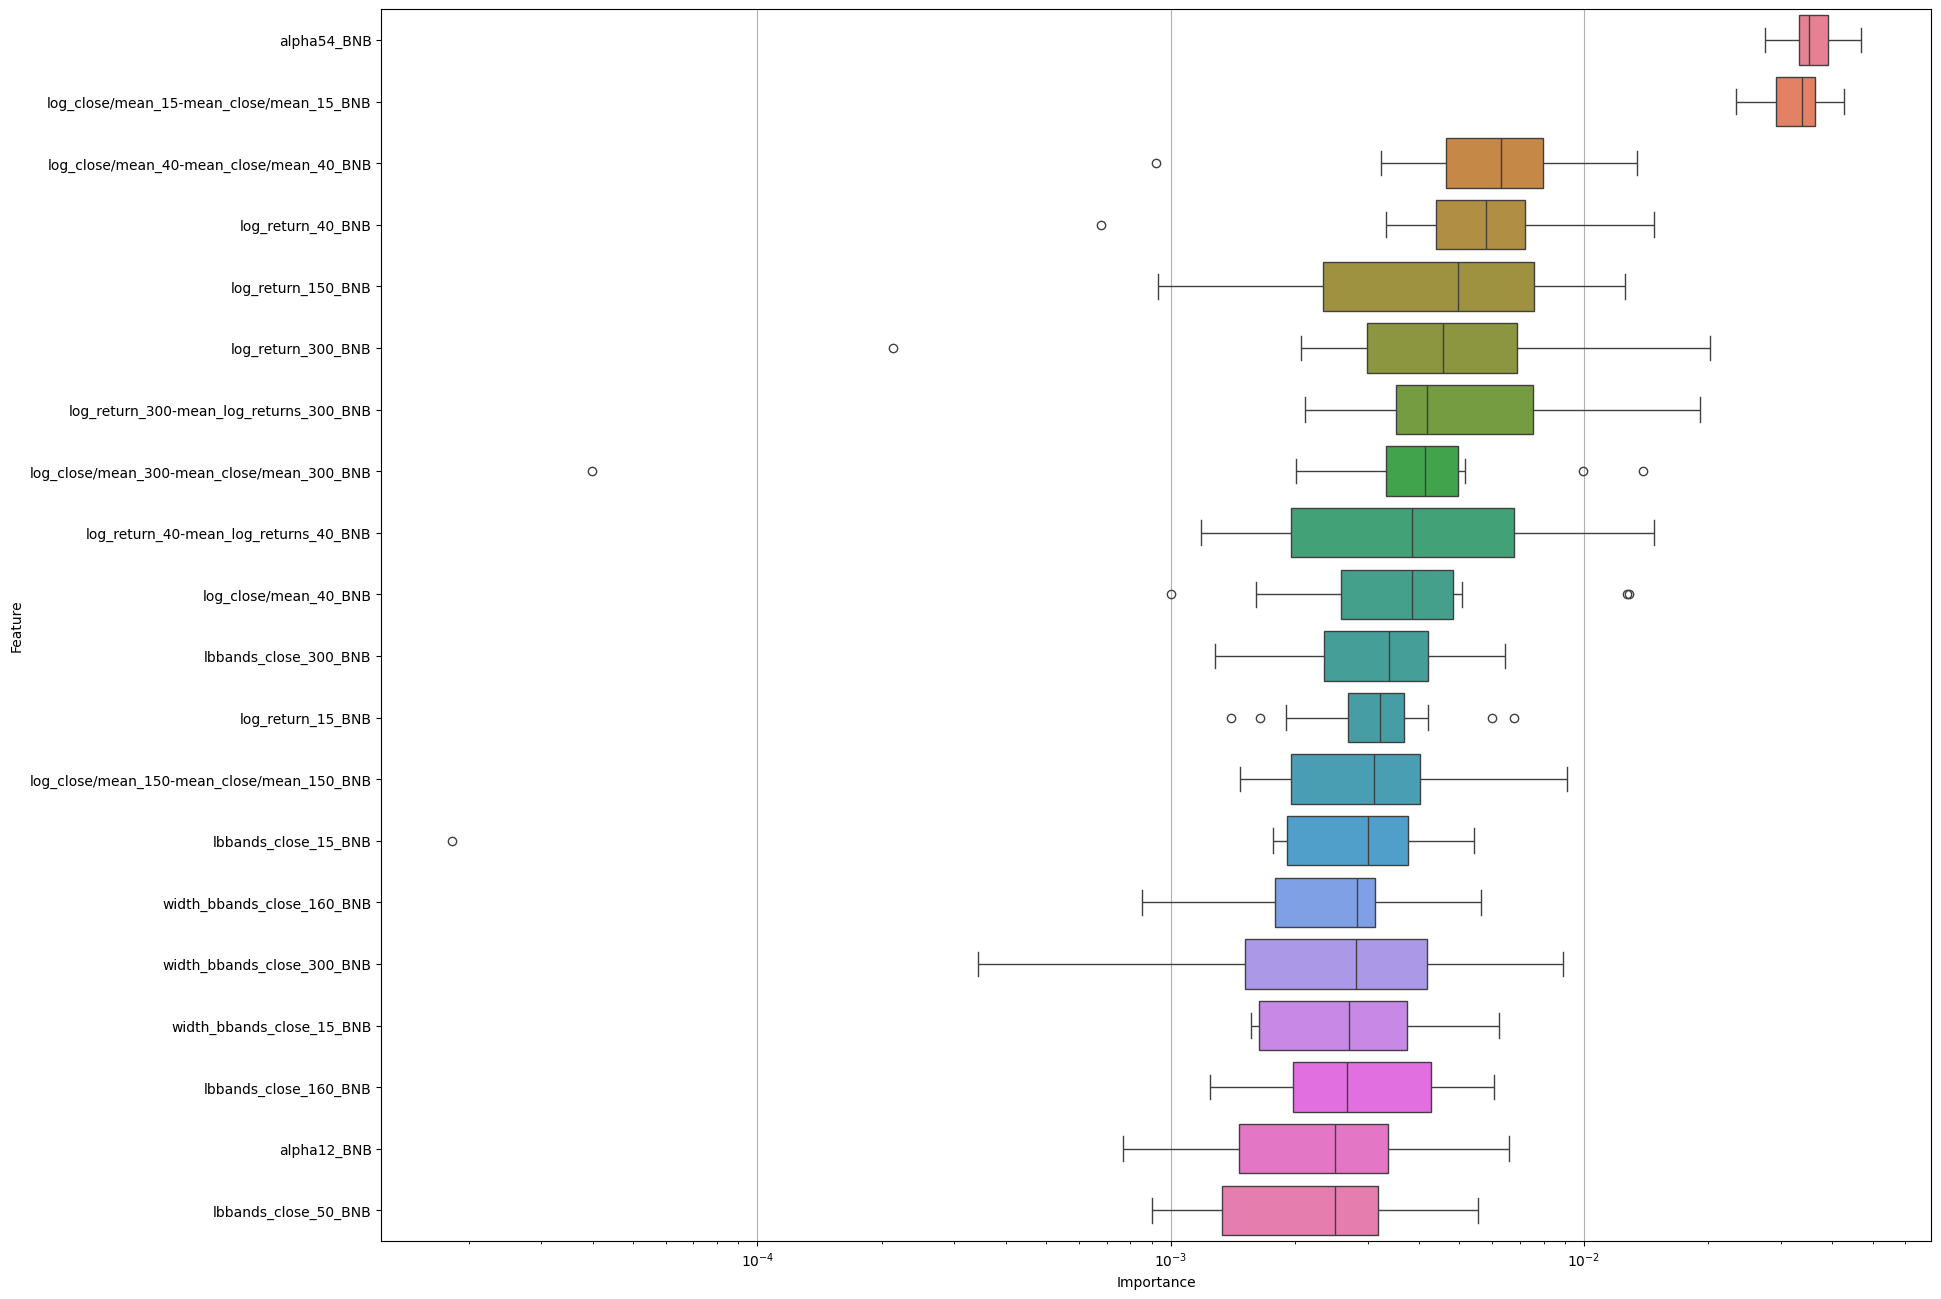

Training TRX with params: {'early_stopping_rounds': 5, 'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'bagging_freq': 1, 'seed': 20, 'feature_fraction_seed': 20, 'bagging_fraction_seed': 20, 'data_random_seed': 20, 'extra_trees': True, 'extra_seed': 20, 'zero_as_missing': True, 'first_metric_only': True, 'max_depth': 5, 'lambda_l1': 0.0675613001654293, 'lambda_l2': 0.01034066164902201, 'learning_rate': 0.09127841477093228, 'min_data_in_leaf': 150, 'num_leaves': 28, 'feature_fraction': 1, 'bagging_fraction': 0.9221832643387833, 'max_bin': 358}
Features: Index(['close_TRX', 'log_close/mean_15_TRX', 'log_return_15_TRX',
       'log_close/mean_40_TRX', 'log_return_40_TRX', 'log_close/mean_150_TRX',
       'log_return_150_TRX', 'log_close/mean_300_TRX', 'log_return_300_TRX',
       'log_close/mean_15-mean_close/mean_15_TRX',
       'log_return_15-mean_log_returns_15_TRX',
       'log_close/mean_40-mean_close/mean_40_TRX',
       'log_return_40-mean_lo

c:\Users\e0817820\AppData\Local\anaconda3\envs\tokka\Lib\site-packages\matplotlib\scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


<Figure size 640x480 with 0 Axes>

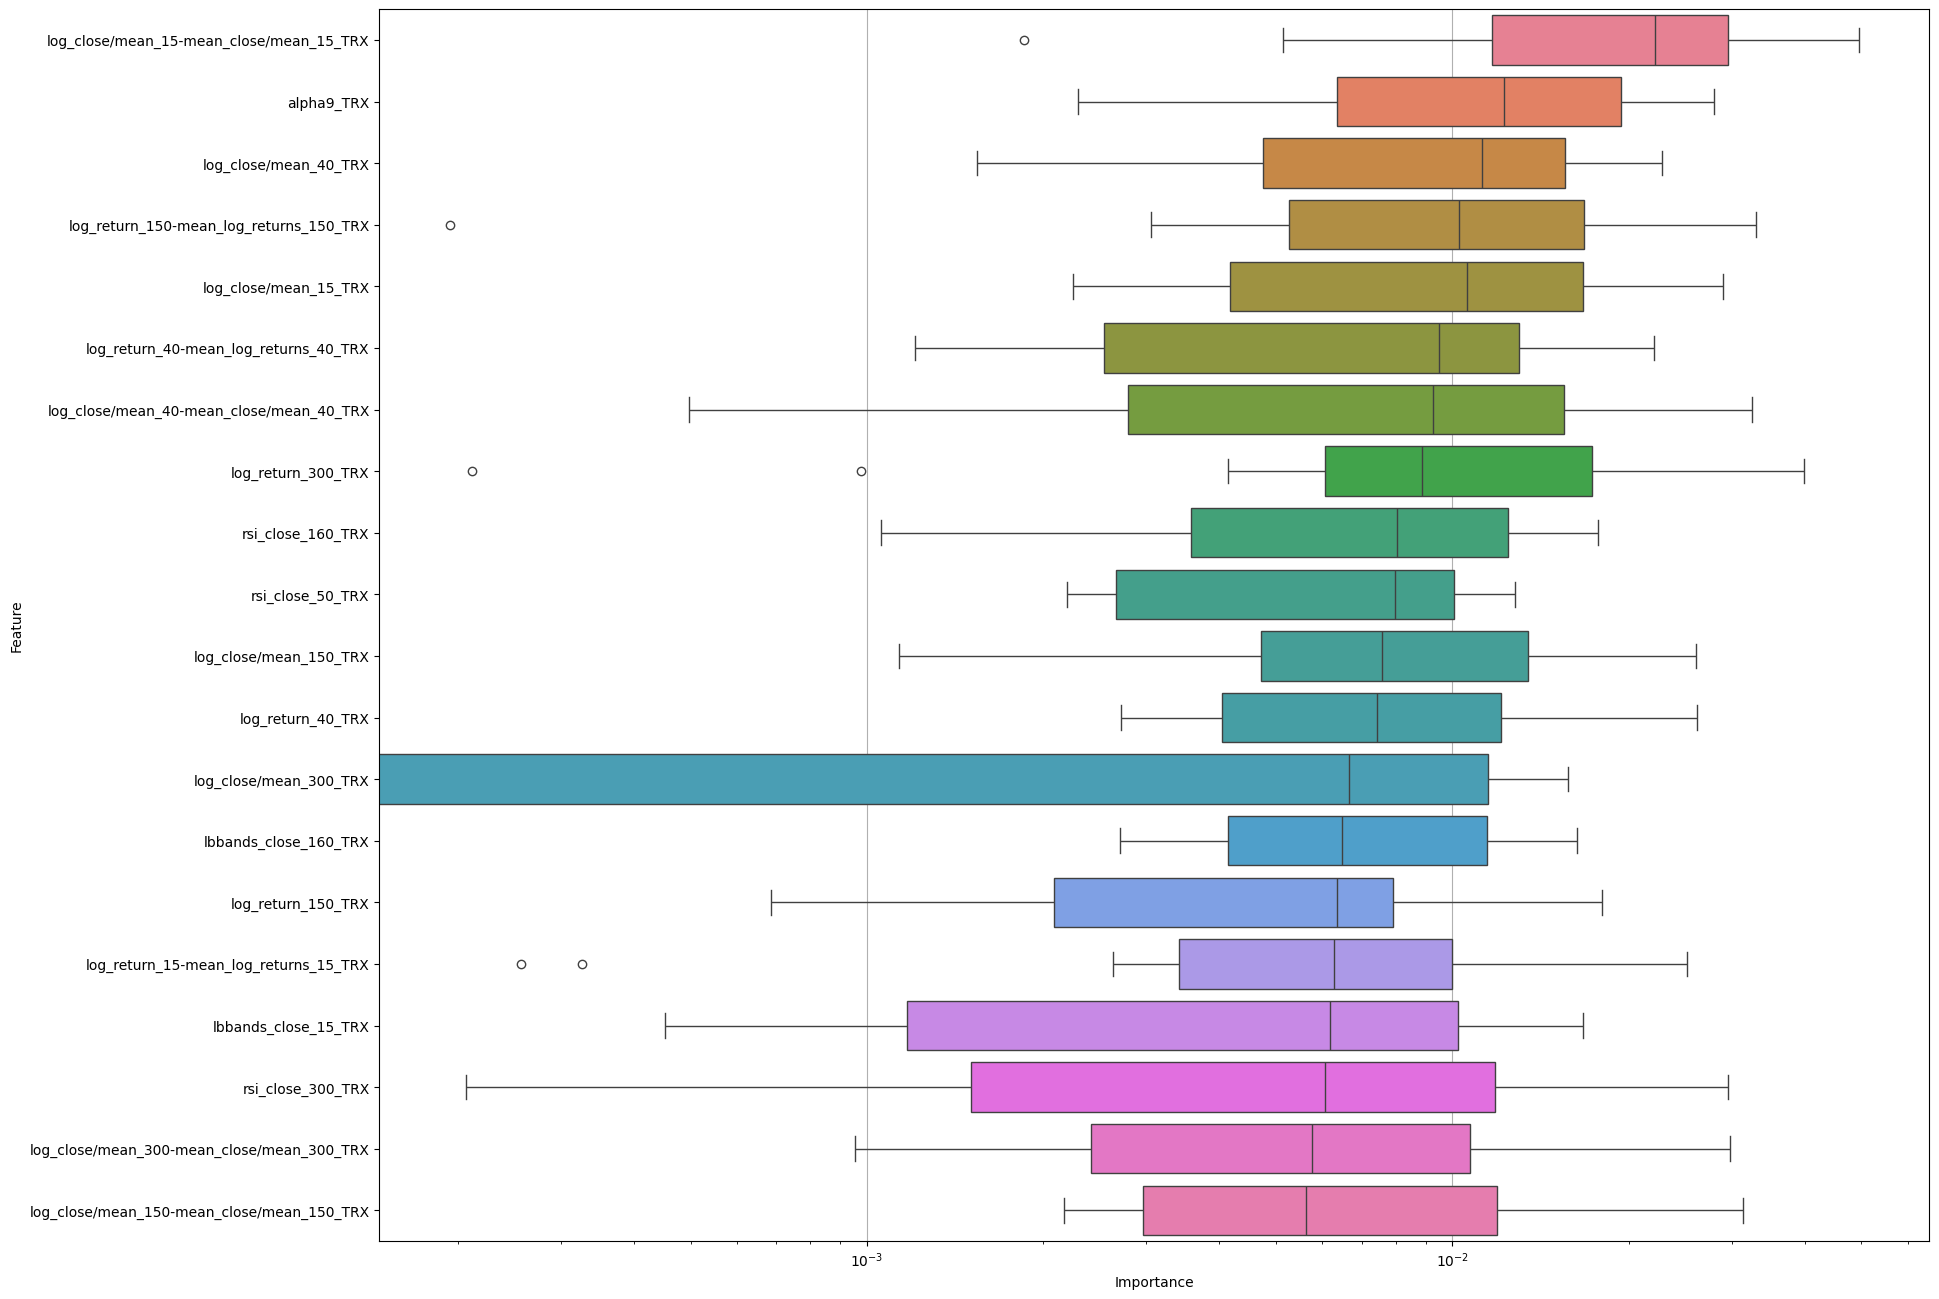

Training DOGE with params: {'early_stopping_rounds': 5, 'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'bagging_freq': 1, 'seed': 20, 'feature_fraction_seed': 20, 'bagging_fraction_seed': 20, 'data_random_seed': 20, 'extra_trees': True, 'extra_seed': 20, 'zero_as_missing': True, 'first_metric_only': True, 'max_depth': 5, 'lambda_l1': 0.0675613001654293, 'lambda_l2': 0.01034066164902201, 'learning_rate': 0.09127841477093228, 'min_data_in_leaf': 150, 'num_leaves': 28, 'feature_fraction': 1, 'bagging_fraction': 0.9221832643387833, 'max_bin': 358}
Features: Index(['close_DOGE', 'log_close/mean_15_DOGE', 'log_return_15_DOGE',
       'log_close/mean_40_DOGE', 'log_return_40_DOGE',
       'log_close/mean_150_DOGE', 'log_return_150_DOGE',
       'log_close/mean_300_DOGE', 'log_return_300_DOGE',
       'log_close/mean_15-mean_close/mean_15_DOGE',
       'log_return_15-mean_log_returns_15_DOGE',
       'log_close/mean_40-mean_close/mean_40_DOGE',
       'l

<Figure size 640x480 with 0 Axes>

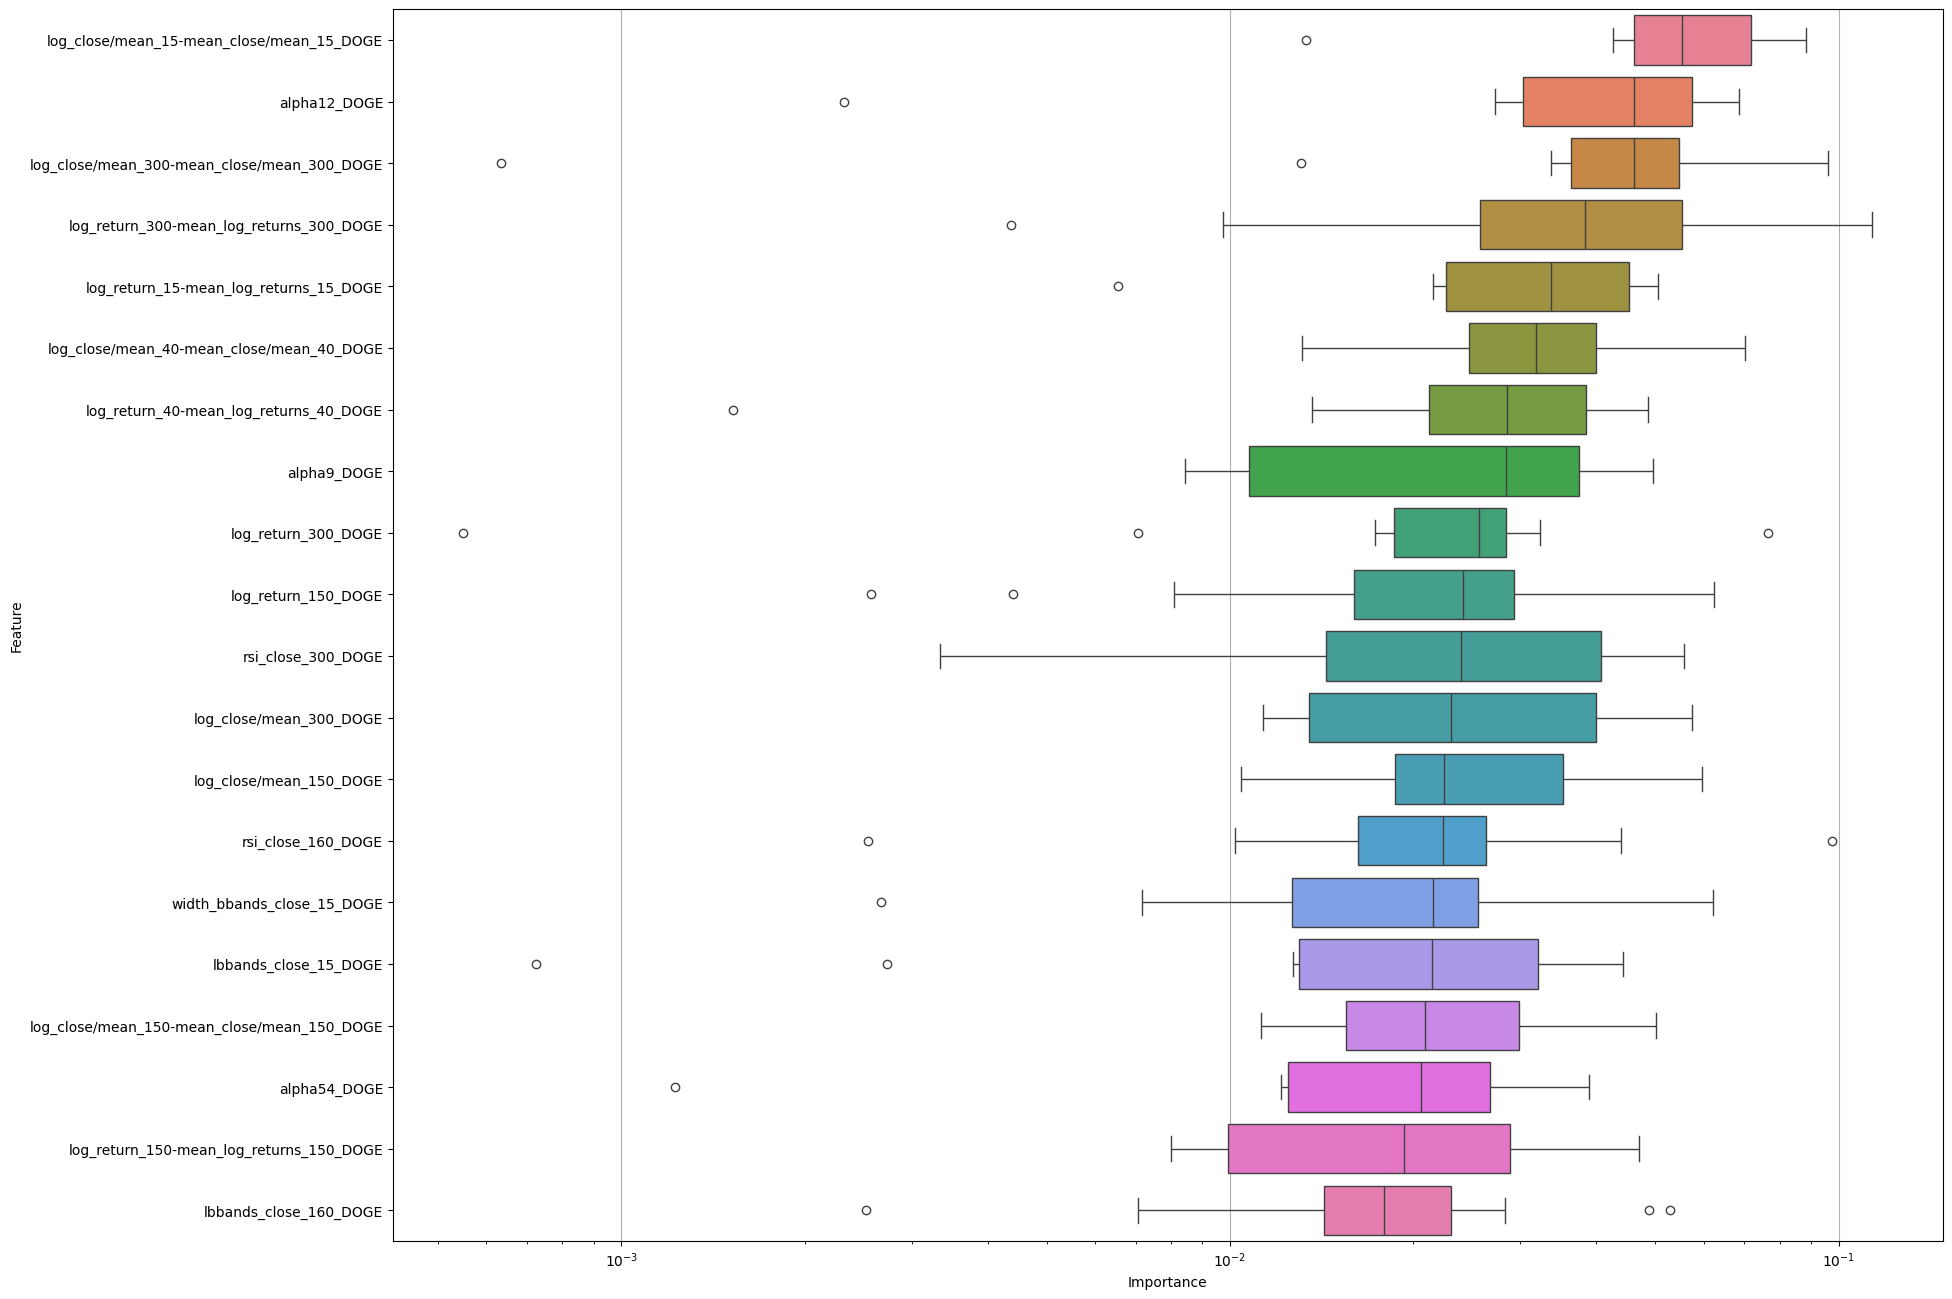

Training LINK with params: {'early_stopping_rounds': 5, 'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'bagging_freq': 1, 'seed': 20, 'feature_fraction_seed': 20, 'bagging_fraction_seed': 20, 'data_random_seed': 20, 'extra_trees': True, 'extra_seed': 20, 'zero_as_missing': True, 'first_metric_only': True, 'max_depth': 5, 'lambda_l1': 0.0675613001654293, 'lambda_l2': 0.01034066164902201, 'learning_rate': 0.09127841477093228, 'min_data_in_leaf': 150, 'num_leaves': 28, 'feature_fraction': 1, 'bagging_fraction': 0.9221832643387833, 'max_bin': 358}
Features: Index(['close_LINK', 'log_close/mean_15_LINK', 'log_return_15_LINK',
       'log_close/mean_40_LINK', 'log_return_40_LINK',
       'log_close/mean_150_LINK', 'log_return_150_LINK',
       'log_close/mean_300_LINK', 'log_return_300_LINK',
       'log_close/mean_15-mean_close/mean_15_LINK',
       'log_return_15-mean_log_returns_15_LINK',
       'log_close/mean_40-mean_close/mean_40_LINK',
       'l

<Figure size 640x480 with 0 Axes>

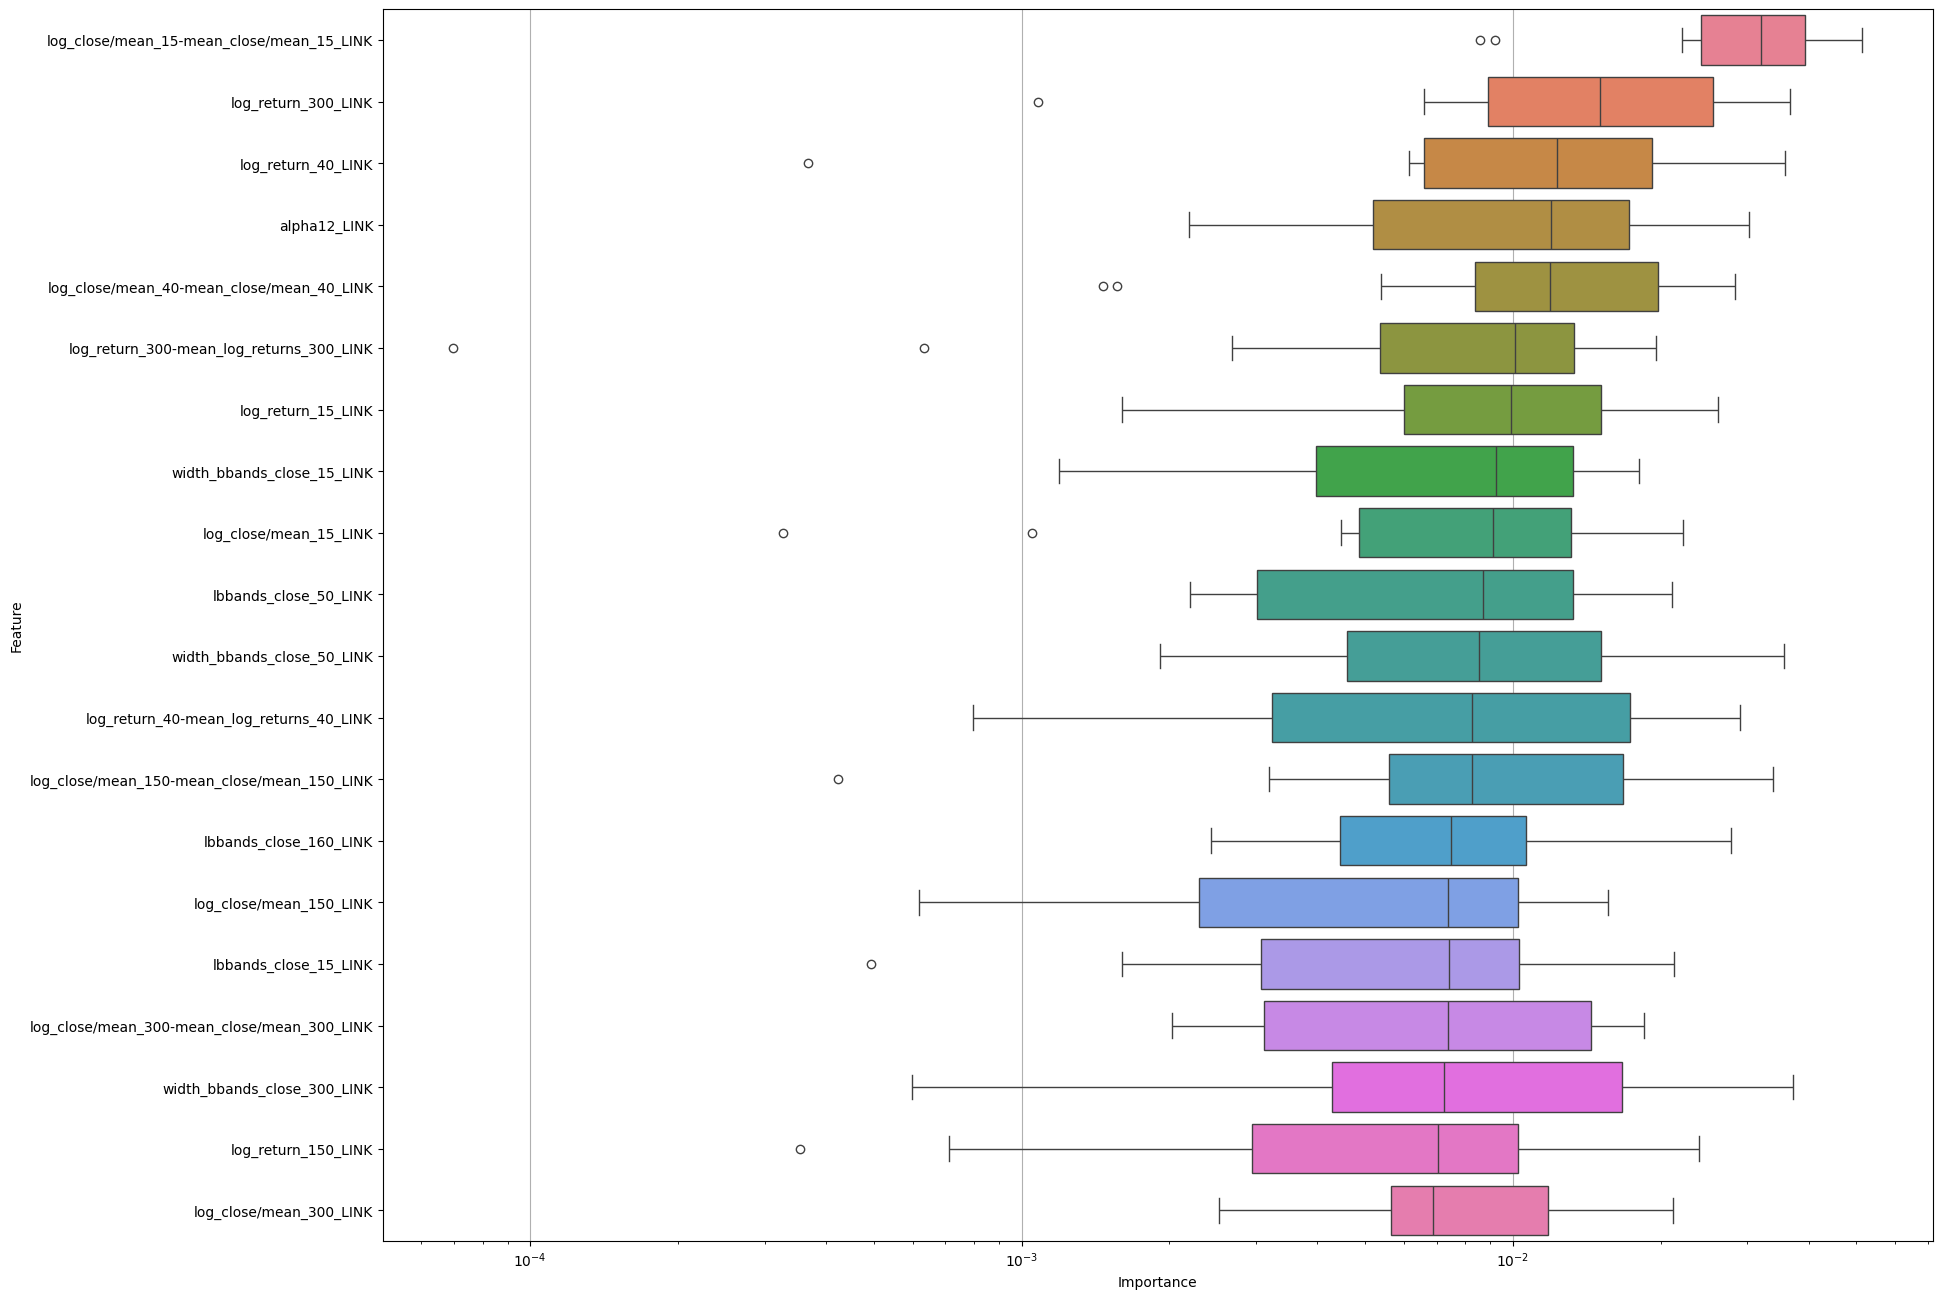

Training XRP with params: {'early_stopping_rounds': 5, 'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'bagging_freq': 1, 'seed': 20, 'feature_fraction_seed': 20, 'bagging_fraction_seed': 20, 'data_random_seed': 20, 'extra_trees': True, 'extra_seed': 20, 'zero_as_missing': True, 'first_metric_only': True, 'max_depth': 5, 'lambda_l1': 0.0675613001654293, 'lambda_l2': 0.01034066164902201, 'learning_rate': 0.09127841477093228, 'min_data_in_leaf': 150, 'num_leaves': 28, 'feature_fraction': 1, 'bagging_fraction': 0.9221832643387833, 'max_bin': 358}
Features: Index(['close_XRP', 'log_close/mean_15_XRP', 'log_return_15_XRP',
       'log_close/mean_40_XRP', 'log_return_40_XRP', 'log_close/mean_150_XRP',
       'log_return_150_XRP', 'log_close/mean_300_XRP', 'log_return_300_XRP',
       'log_close/mean_15-mean_close/mean_15_XRP',
       'log_return_15-mean_log_returns_15_XRP',
       'log_close/mean_40-mean_close/mean_40_XRP',
       'log_return_40-mean_lo

<Figure size 640x480 with 0 Axes>

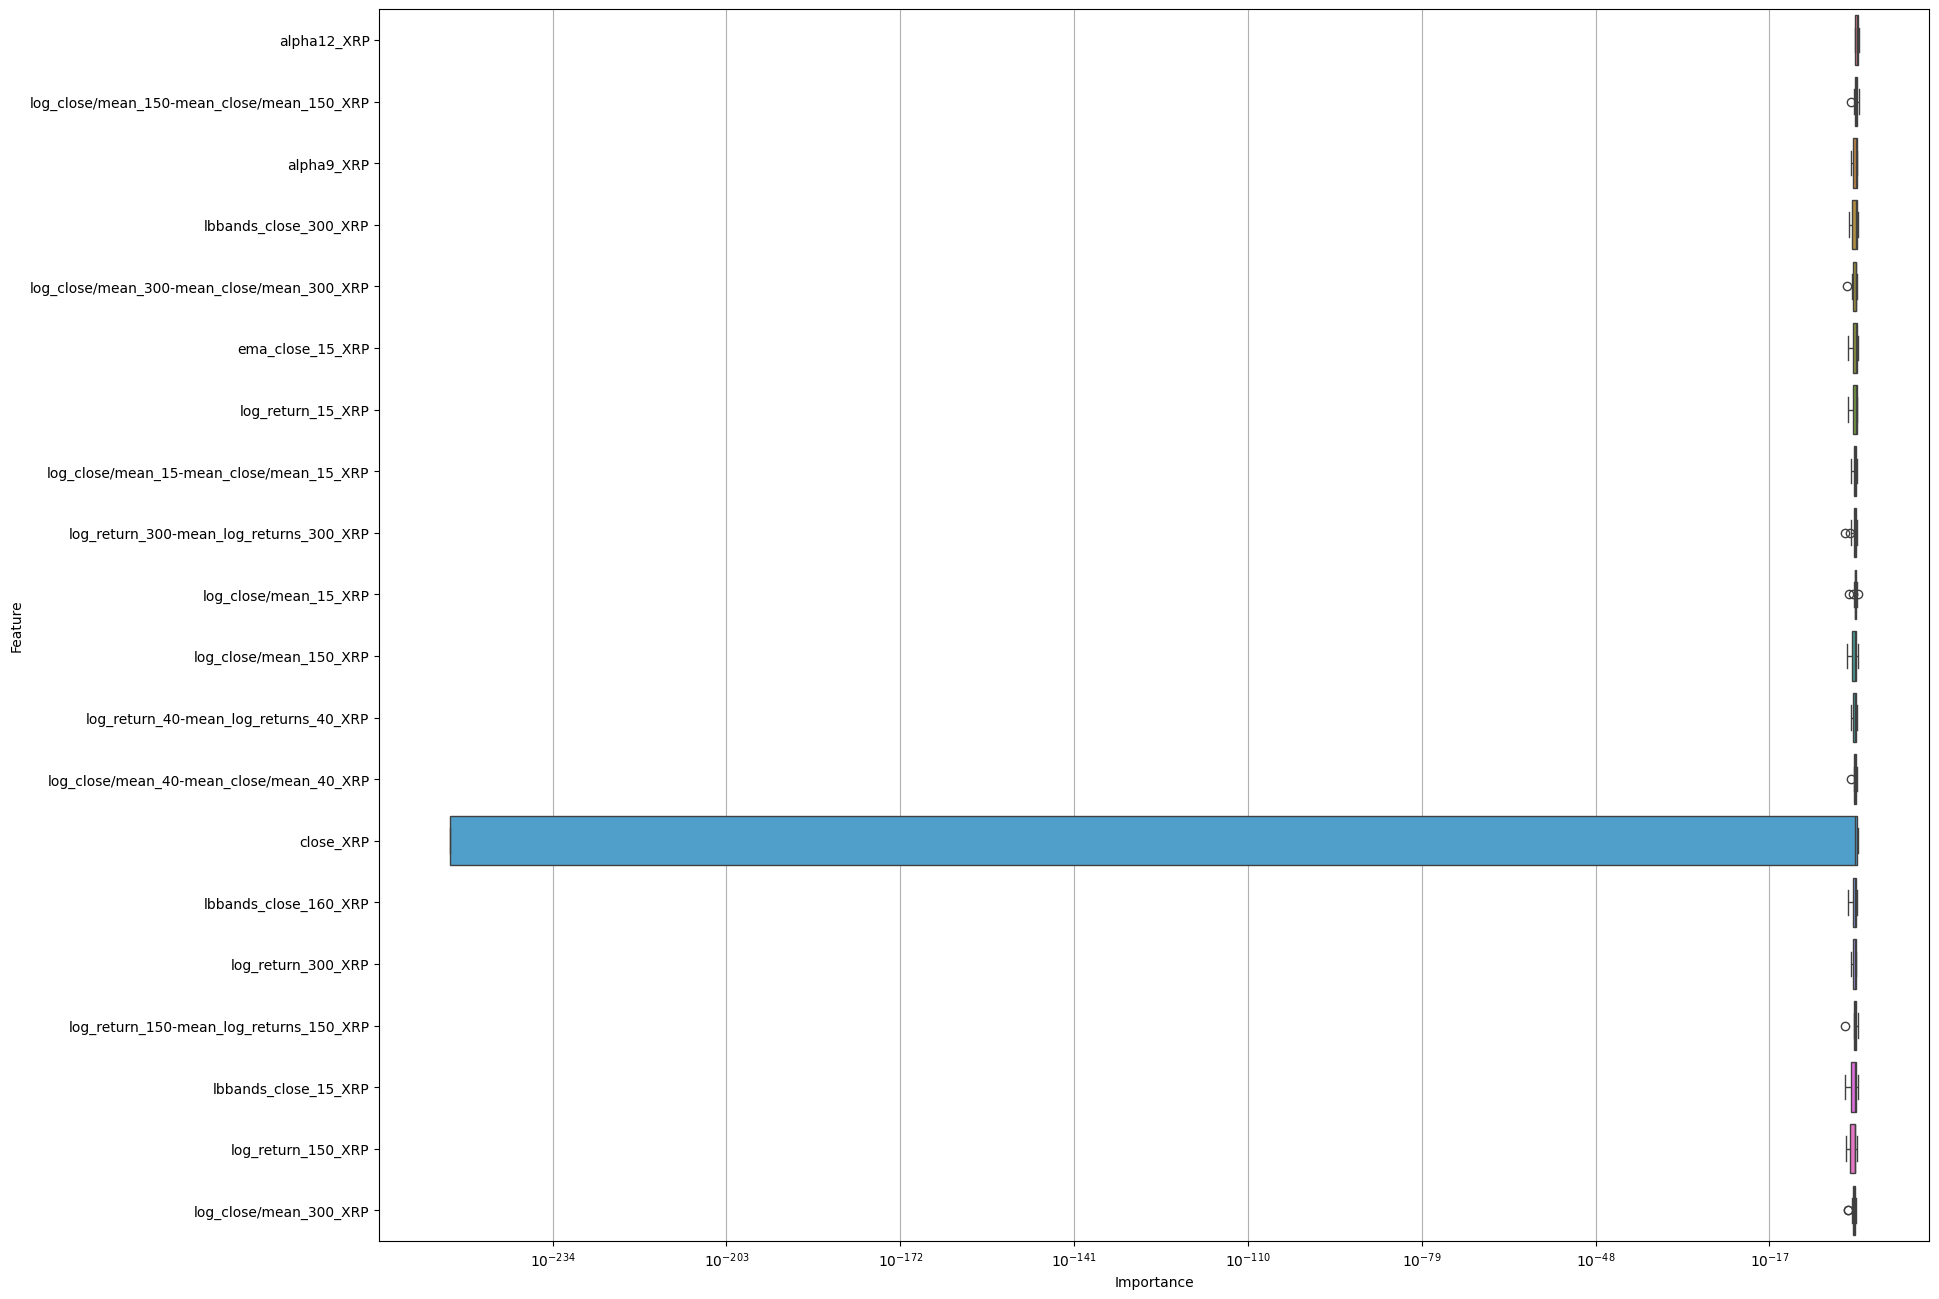

Training BTC with params: {'early_stopping_rounds': 5, 'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'bagging_freq': 1, 'seed': 20, 'feature_fraction_seed': 20, 'bagging_fraction_seed': 20, 'data_random_seed': 20, 'extra_trees': True, 'extra_seed': 20, 'zero_as_missing': True, 'first_metric_only': True, 'max_depth': 5, 'lambda_l1': 0.0675613001654293, 'lambda_l2': 0.01034066164902201, 'learning_rate': 0.09127841477093228, 'min_data_in_leaf': 150, 'num_leaves': 28, 'feature_fraction': 1, 'bagging_fraction': 0.9221832643387833, 'max_bin': 358}
Features: Index(['close_BTC', 'log_close/mean_15_BTC', 'log_return_15_BTC',
       'log_close/mean_40_BTC', 'log_return_40_BTC', 'log_close/mean_150_BTC',
       'log_return_150_BTC', 'log_close/mean_300_BTC', 'log_return_300_BTC',
       'log_close/mean_15-mean_close/mean_15_BTC',
       'log_return_15-mean_log_returns_15_BTC',
       'log_close/mean_40-mean_close/mean_40_BTC',
       'log_return_40-mean_lo

c:\Users\e0817820\AppData\Local\anaconda3\envs\tokka\Lib\site-packages\matplotlib\scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


<Figure size 640x480 with 0 Axes>

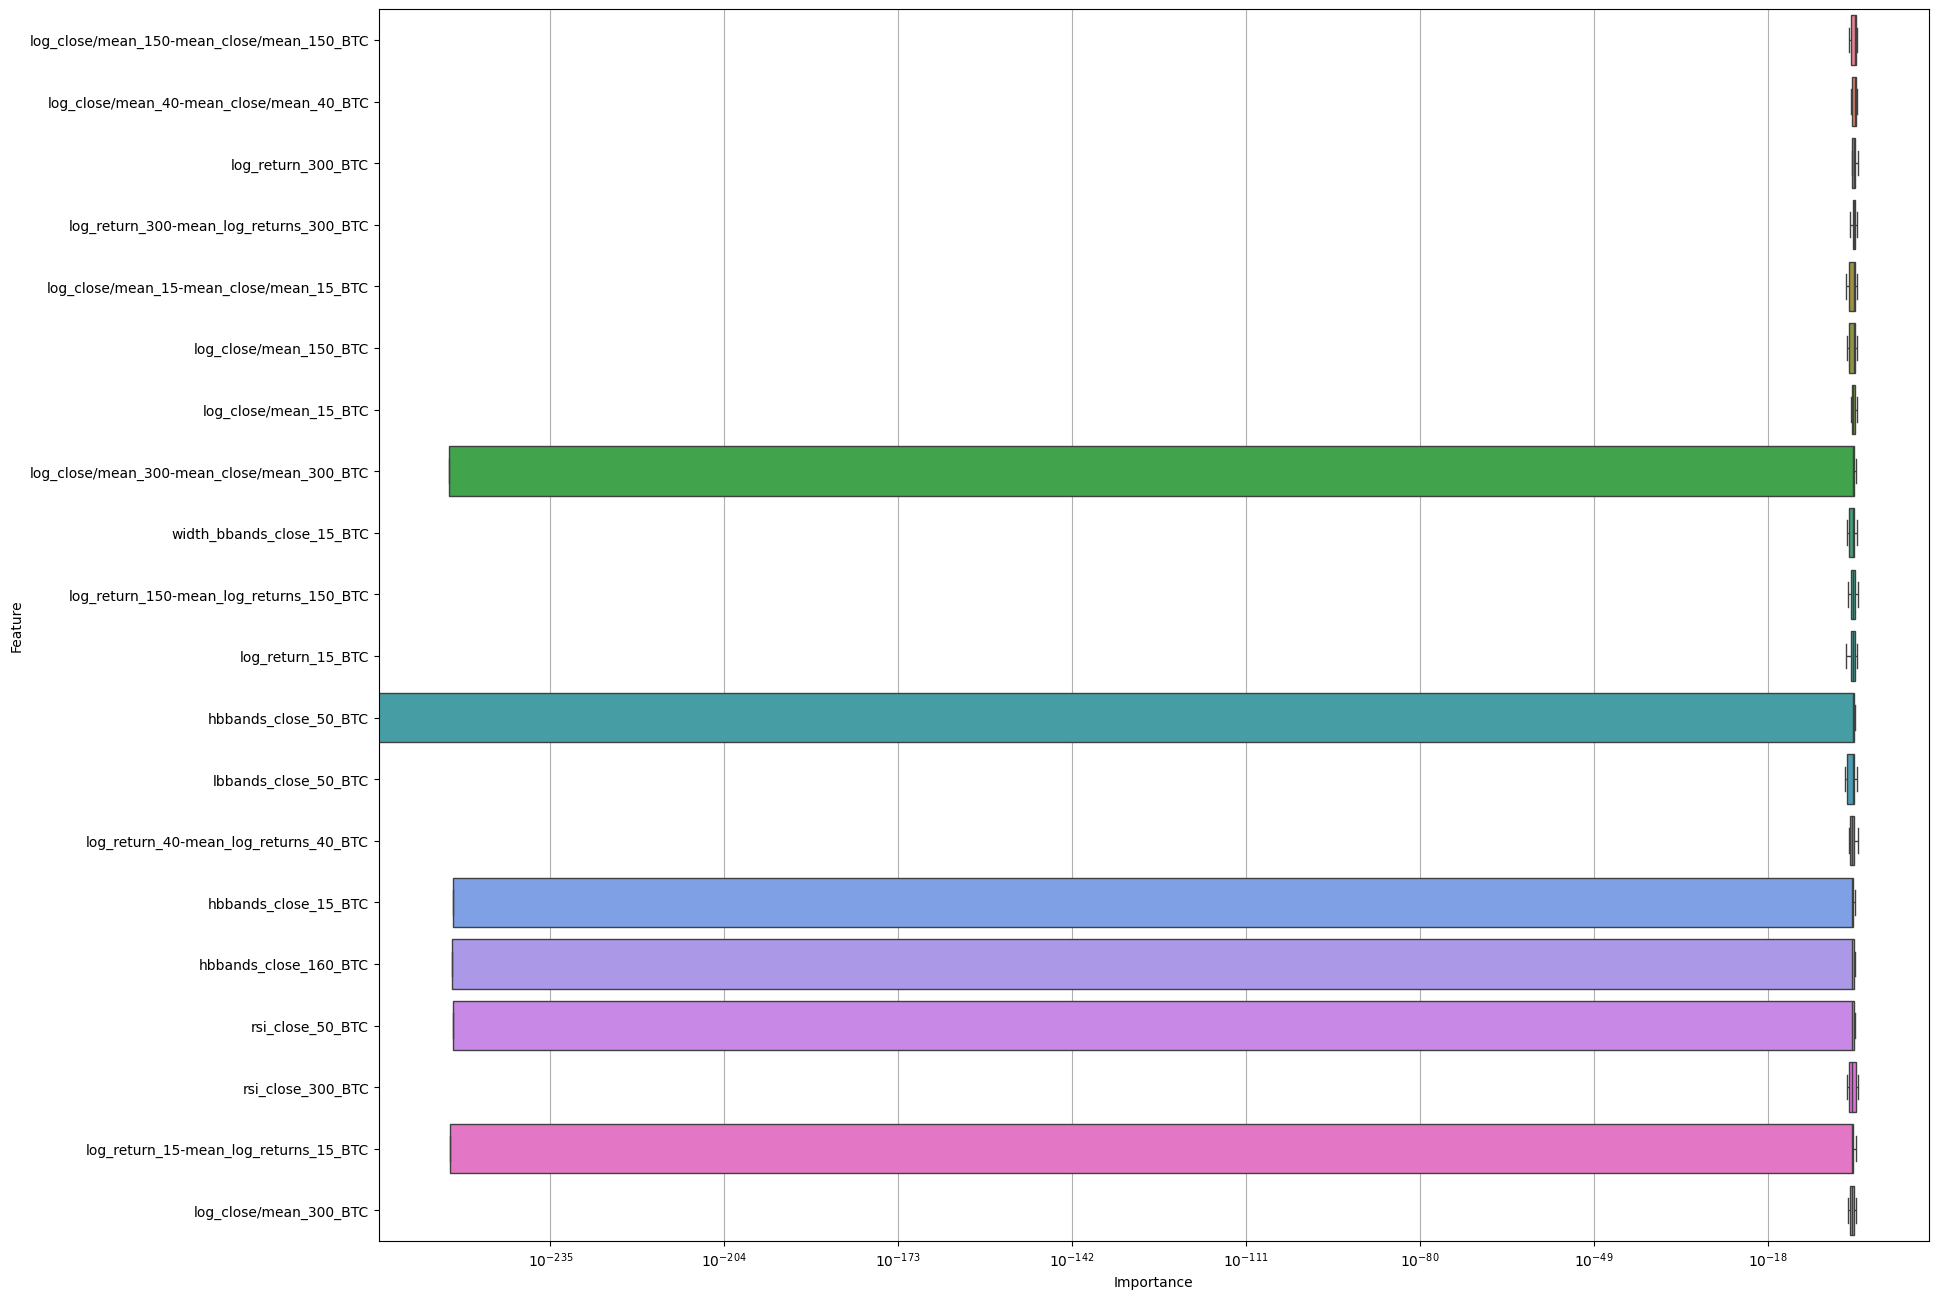

Training ETH with params: {'early_stopping_rounds': 5, 'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'bagging_freq': 1, 'seed': 20, 'feature_fraction_seed': 20, 'bagging_fraction_seed': 20, 'data_random_seed': 20, 'extra_trees': True, 'extra_seed': 20, 'zero_as_missing': True, 'first_metric_only': True, 'max_depth': 5, 'lambda_l1': 0.0675613001654293, 'lambda_l2': 0.01034066164902201, 'learning_rate': 0.09127841477093228, 'min_data_in_leaf': 150, 'num_leaves': 28, 'feature_fraction': 1, 'bagging_fraction': 0.9221832643387833, 'max_bin': 358}
Features: Index(['close_ETH', 'log_close/mean_15_ETH', 'log_return_15_ETH',
       'log_close/mean_40_ETH', 'log_return_40_ETH', 'log_close/mean_150_ETH',
       'log_return_150_ETH', 'log_close/mean_300_ETH', 'log_return_300_ETH',
       'log_close/mean_15-mean_close/mean_15_ETH',
       'log_return_15-mean_log_returns_15_ETH',
       'log_close/mean_40-mean_close/mean_40_ETH',
       'log_return_40-mean_lo

<Figure size 640x480 with 0 Axes>

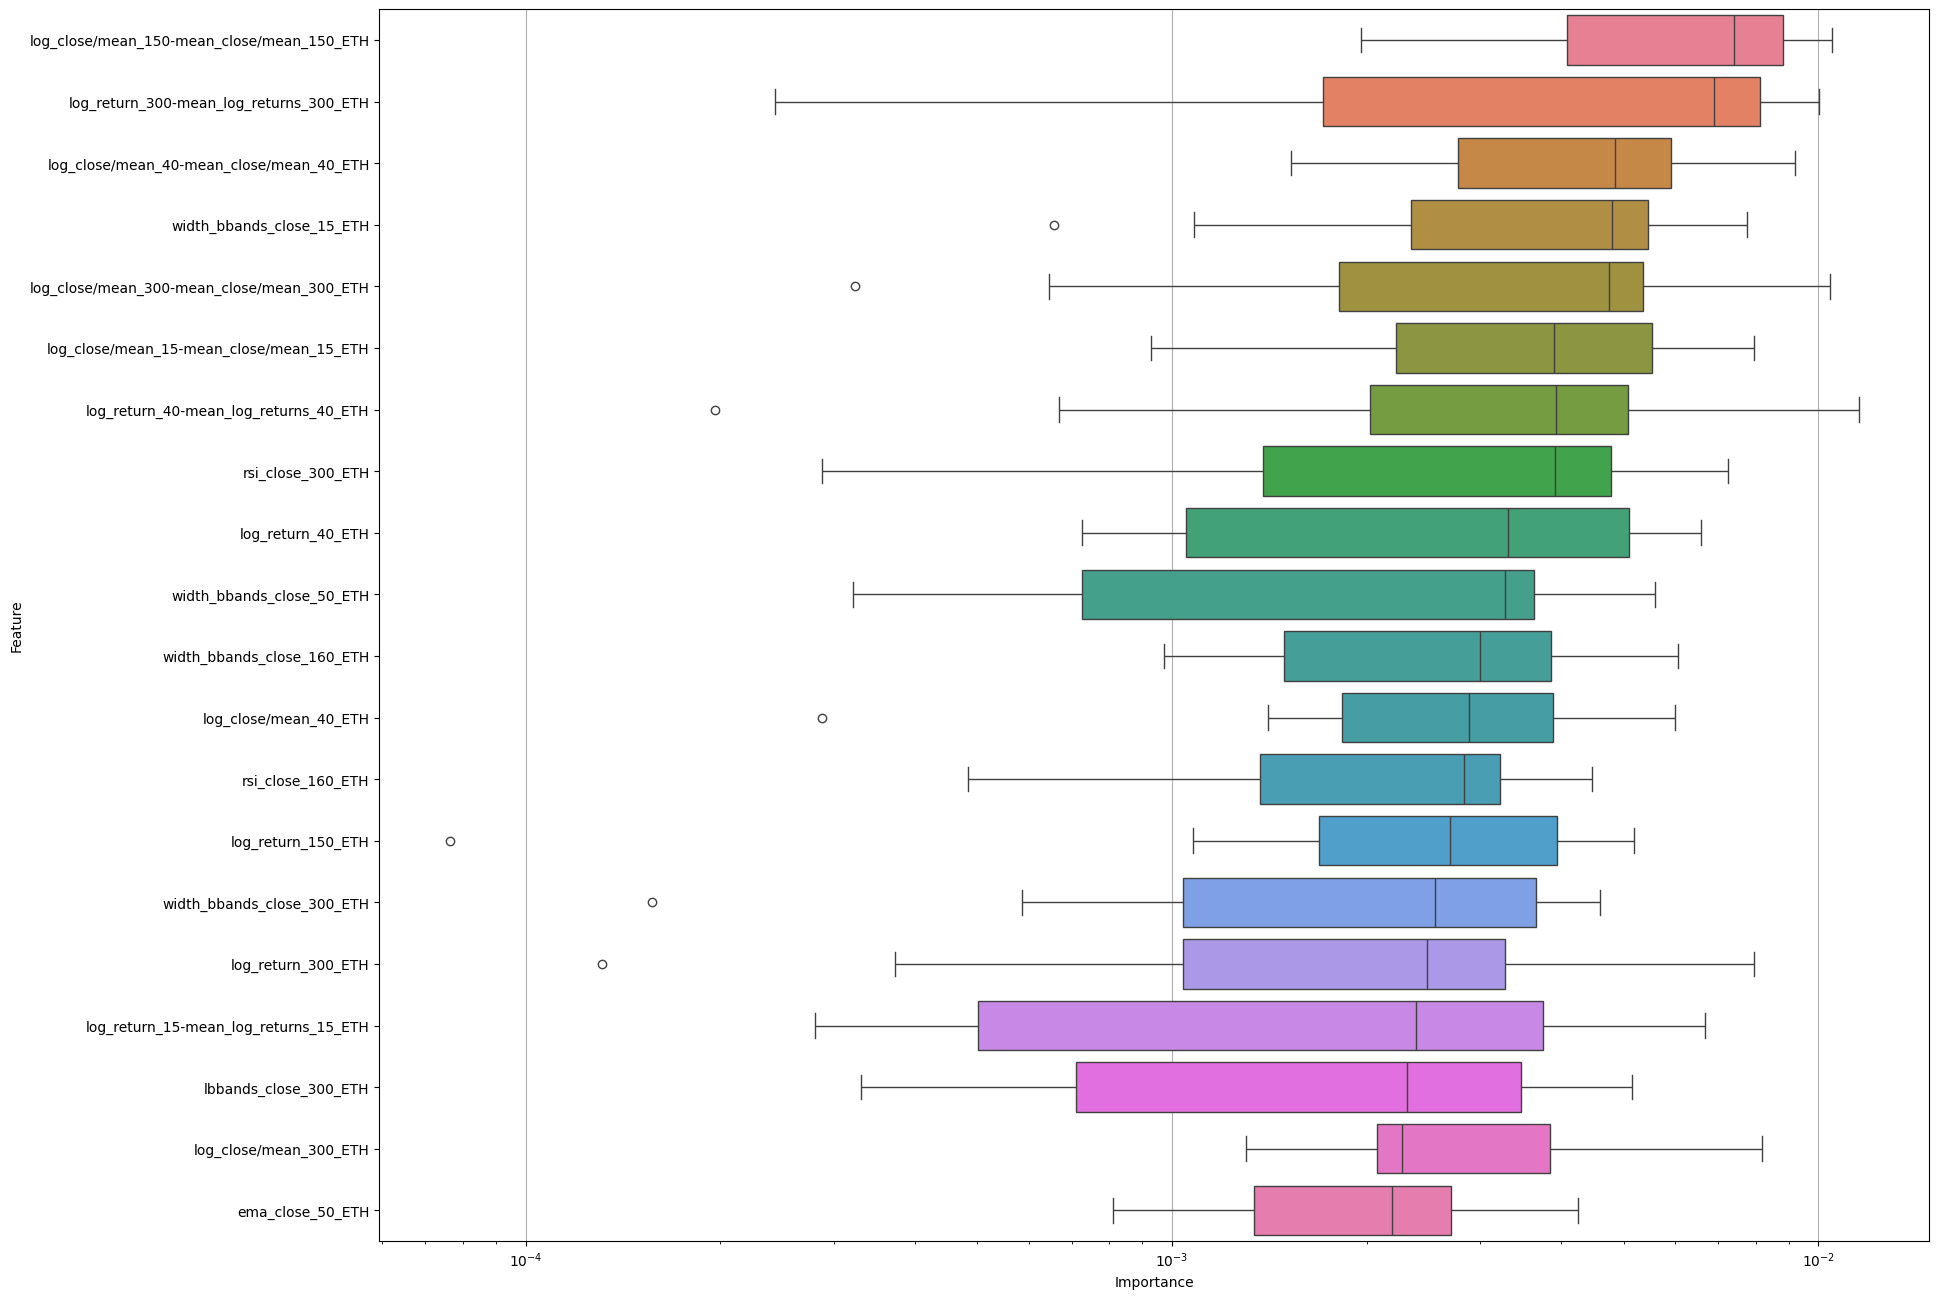

<Figure size 640x480 with 0 Axes>

In [6]:
crypto_corrs, crypto_oof_pred, crypto_oof_valid, crypto_avg_corrs = train()